In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

from datasets import datasets
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

seed = 1

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.01

# desired quanitile levels
quantiles = [alpha / 2, 1 - (alpha /2)]

# used to determine the size of test set
test_ratio = 0.2



In [2]:
# # name of dataset
# dataset_base_path = "./datasets/"
# dataset_name = "community"

# # load the dataset
# X, y = datasets.GetDataset(dataset_name, dataset_base_path)

# # divide the dataset into test and train based on the test_ratio parameter
# x_train, x_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=test_ratio,
#                                                     random_state=random_state_train_test)

# # reshape the data
# x_train = np.asarray(x_train)
# y_train = np.asarray(y_train)
# x_test = np.asarray(x_test)
# y_test = np.asarray(y_test)

# # compute input dimensions
# n_train = x_train.shape[0]
# in_shape = x_train.shape[1]

# # display basic information
# print("Dataset: %s" % (dataset_name))
# print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
#       (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

In [3]:
# # divide the data into proper training set and calibration set
# idx = np.random.permutation(n_train)
# n_half = int(np.floor(n_train/2))
# idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

# # zero mean and unit variance scaling 
# scalerX = StandardScaler()
# scalerX = scalerX.fit(x_train[idx_train])

# # scale
# x_train = scalerX.transform(x_train)
# x_test = scalerX.transform(x_test)

# # scale the labels by dividing each by the mean absolute response
# mean_y_train = np.mean(np.abs(y_train[idx_train]))
# y_train = np.squeeze(y_train)/mean_y_train
# y_test = np.squeeze(y_test)/mean_y_train

In [4]:
# number of training examples
n_train = 2000
# number of test examples (to evaluate average coverage and length)
n_test = 5000

def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(np.float32)

# training features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)

# test features
x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

# generate labels
y_train = f(x_train)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train,1))
x_test = np.reshape(x_test,(n_test,1))

In [5]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

In [6]:
class Net(torch.nn.Module):
    def __init__(self, n_feature):
        super(Net, self).__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(n_feature, 64),
                                       torch.nn.ReLU(),
                                       #torch.nn.Dropout(0.1),
                                       torch.nn.Linear(64, 64),
                                       torch.nn.ReLU(),
                                       #torch.nn.Dropout(0.1),
                                       torch.nn.Linear(64, 2)
        )
        self.init_weights()
    
    def init_weights(self):
        for m in self.net:
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.orthogonal_(m.weight)
                torch.nn.init.constant_(m.bias, 0)
        

    def forward(self, x):
        x = self.net(x)             # linear output
        return x

In [20]:
net = Net(n_feature=1) 
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-6)
def loss_func(y, yhat, alpha):
    return torch.maximum(alpha*(y-yhat),(1-alpha)*(yhat-y))

In [21]:
tensor_xtrain = torch.Tensor(x_train[idx_train]) # transform to torch tensor
tensor_ytrain = torch.Tensor(y_train[idx_train])

train_dataset = TensorDataset(tensor_xtrain,tensor_ytrain) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) # create your dataloader

tensor_xcal = torch.Tensor(x_train[idx_cal]) # transform to torch tensor
tensor_ycal = torch.Tensor(y_train[idx_cal])

cal_dataset = TensorDataset(tensor_xcal,tensor_ycal) # create your datset
cal_dataloader = DataLoader(cal_dataset, batch_size=400, shuffle=False) # create your dataloader

tensor_xtest = torch.Tensor(x_test) # transform to torch tensor
tensor_ytest = torch.Tensor(y_test)

test_dataset = TensorDataset(tensor_xtest,tensor_ytest) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=400, shuffle=False) # create your dataloader

In [22]:
net.train()
for t in tqdm(range(1000)):
    itera = iter(train_dataloader)
    for i in range(len(itera)):
        x,y = next(itera)
        prediction = net(x)     # input x and predict based on x

        loss1 = loss_func(y, prediction[:,0], quantiles[0])
        loss2 = loss_func(y, prediction[:,1], quantiles[1])
        loss = (loss1+loss2).mean()

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


In [23]:
def predict(net, dataloader):
    iteracal = iter(dataloader)
    xs = []
    ys = []
    preds = []
    net.eval()
    for i in range(len(iteracal)):
        x,y = next(iteracal)
        with torch.no_grad():
            prediction = net(x)     # input x and predict based on x

            #loss = loss_func(y, prediction[:,0], quantiles[0])
            #loss = loss_func(y, prediction[:,1], quantiles[1])

            preds.append(prediction.numpy())      # apply gradients
            xs.append(x)
            ys.append(y)
    preds = np.concatenate(preds)
    xs = np.concatenate(xs)
    ys = np.concatenate(ys)
    return xs, ys, preds

In [24]:
def conformalize(net, cal_dataloader, alpha):
    xs, ys, preds = predict(net, cal_dataloader)
    E = np.maximum(preds[:,0]-ys, ys-preds[:,1])
    E = np.sort(E)
    quantile = (1-alpha)*(1+(1/len(E)))*len(E)
    print("Quantile of E :", quantile)
    quantile = int(np.ceil(quantile))
    print("Quantile of E (ceil):", quantile)
    Q = E[quantile]
    return Q

In [25]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False,
              zoom=True):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """

    max_show = 1000
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    if zoom:
        plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [26]:
xt, yt, predt = predict(net, test_dataloader)
Q = conformalize(net, cal_dataloader, alpha)
final_predt = predt + np.array([[-Q, Q]])

Quantile of E : 990.9899999999999
Quantile of E (ceil): 991


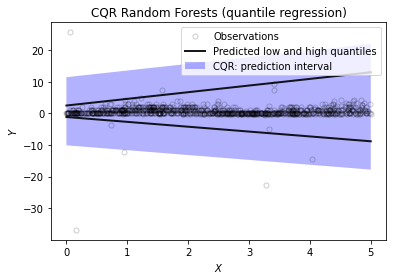

In [27]:
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'blue'

plot_func(x_test, y_test, final_predt[:,0], final_predt[:,1], pred=predt,
          shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",zoom=False)

In [28]:
def conformality_score(y, C):
    score = np.logical_and(y>=C[:,0],y<=C[:,1])
    return score.mean()

In [29]:
conformality_score(yt, predt)

0.9948

In [30]:
conformality_score(yt, final_predt)

0.997

In [31]:
Q

8.953573

In [32]:
(final_predt[:,1]-final_predt[:,0]).mean()

30.545528